In [1]:
import os
import torch
import wandb
import numpy as np
from PIL import Image

from models.Embedding import Embedding
from models.Alignment import Alignment
from models.Blending import Blending

In [2]:
wandb.login()
wandb.init(
    project="barbershop",
    entity="geekyrakshit",
    job_type="test"
)

config = wandb.config
config.wandb_project = 'barbershop'
config.wandb_entity = None
config.images_artifact = 'geekyrakshit/barbershop/II2S-Images:v0'
config.ffhq_models_artifact = 'geekyrakshit/barbershop/ffhq:v0'
config.segmentation_models_artifact = 'geekyrakshit/barbershop/segmentation:v0'
config.output_dir = 'output'
config.identity_image = '90.png'
config.structure_image = '15.png'
config.appearance_image = '117.png'
config.sign = 'realistic'
config.smooth = 5
config.size = 1024
config.channel_multiplier = 2
config.latent = 512
config.n_mlp = 8
config.device = "cuda"
config.seed = None
config.tile_latent = False
config.opt_name = 'adam'
config.learning_rate = 0.01
config.lr_schedule = 'fixed'
config.save_intermediate = False
config.save_interval = 300
config.verbose = False
config.percept_lambda = 1.0
config.l2_lambda = 1.0
config.p_norm_lambda = 0.001
config.l_F_lambda = 0.1
config.W_steps = 1100
config.FS_steps = 250
config.ce_lambda = 1.0
config.style_lambda = 40000.0
config.align_steps1 = 140
config.align_steps2 = 100
config.face_lambda = 1.0
config.hair_lambda = 1.0
config.blend_steps = 400

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


In [3]:
images_artifact = wandb.use_artifact(config.images_artifact, type="dataset")
images_artifact_dir = images_artifact.download()

ffhq_model_artifact = wandb.use_artifact(
    config.ffhq_models_artifact, type="model"
)
ffhq_model_artifact_dir = ffhq_model_artifact.download()
ffhq_model_file = os.path.join(ffhq_model_artifact_dir, "ffhq.pt")

segmentation_model_artifact = wandb.use_artifact(
    config.segmentation_models_artifact, type="model"
)
segmentation_model_artifact_dir = segmentation_model_artifact.download()
segmentation_model_file = os.path.join(
    segmentation_model_artifact_dir, "seg.pth"
)

wandb: Downloading large artifact II2S-Images:v0, 155.34MB. 120 files... Done. 0:0:0
wandb: Downloading large artifact ffhq:v0, 126.55MB. 1 files... Done. 0:0:0
wandb: Downloading large artifact segmentation:v0, 50.82MB. 1 files... Done. 0:0:0


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ii2s = Embedding(config, checkpoint_file=ffhq_model_file).to(device=device)

identity_image = os.path.join(images_artifact_dir, config.identity_image)
structure_image = os.path.join(images_artifact_dir, config.structure_image)
appearance_image = os.path.join(images_artifact_dir, config.appearance_image)

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [5]:
align = Alignment(
    config,
    ffhq_checkpoint_file=ffhq_model_file,
    segmentation_checkpoint_file=segmentation_model_file,
).to(device=device)
aligned_image = align.align_images(
    identity_image,
    structure_image,
    sign=config.sign,
    align_more_region=False,
    smooth=config.smooth,
)
if structure_image != appearance_image:
    aligned_image = align.align_images(
        identity_image,
        appearance_image,
        sign=config.sign,
        align_more_region=False,
        smooth=config.smooth,
        save_intermediate=False,
    )

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt


In [6]:
blend = Blending(
    config,
    ffhq_checkpoint_file=ffhq_model_file,
    segmentation_checkpoint_file=segmentation_model_file,
).to(device=device)
blended_image = blend.blend_images(
    identity_image, structure_image, appearance_image, sign=config.sign
)

Loading StyleGAN2 from checkpoint: ./artifacts/ffhq:v0/ffhq.pt
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/masked_lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /home/paperspace/Workspace/Barbershop/losses/masked_lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [7]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Identity Image')

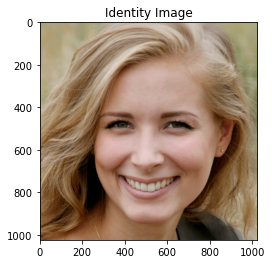

In [9]:
plt.imshow(np.array(Image.open(identity_image)))
plt.title("Identity Image")

Text(0.5, 1.0, 'Structure Image')

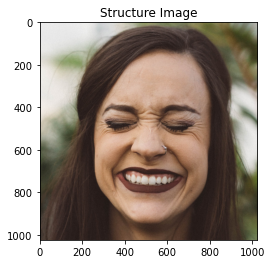

In [10]:
plt.imshow(np.array(Image.open(structure_image)))
plt.title("Structure Image")

In [ ]:
plt.imshow(np.array(Image.open(appearance_image)))
plt.title("Appearance Image")

In [ ]:
aligned_image